In [1]:
import geopandas as gpd
import folium

In [2]:
data = gpd.read_file('filtered dataset/crimes_filtered.shp')

In [5]:
unique_crimes = data['ofns_desc'].unique()

In [6]:
unique_crimes

array(['HARRASSMENT 2', 'ASSAULT 3 & RELATED OFFENSES', 'SEX CRIMES',
       'OFF. AGNST PUB ORD SENSBLTY &', 'FELONY ASSAULT',
       'OFFENSES AGAINST PUBLIC ADMINI', 'GRAND LARCENY',
       'DANGEROUS WEAPONS', 'MISCELLANEOUS PENAL LAW', 'PETIT LARCENY',
       'CRIMINAL MISCHIEF & RELATED OF', 'RAPE', 'FRAUDS',
       'UNAUTHORIZED USE OF A VEHICLE', 'KIDNAPPING & RELATED OFFENSES',
       'ROBBERY', 'MURDER & NON-NEGL. MANSLAUGHTER', 'BURGLARY',
       'THEFT-FRAUD', 'PROSTITUTION & RELATED OFFENSES',
       'DANGEROUS DRUGS', 'ADMINISTRATIVE CODE',
       'OTHER OFFENSES RELATED TO THEF', 'GRAND LARCENY OF MOTOR VEHICLE',
       'CRIMINAL TRESPASS', 'FORGERY', 'OFFENSES AGAINST THE PERSON',
       'CHILD ABANDONMENT/NON SUPPORT', 'POSSESSION OF STOLEN PROPERTY',
       'NYS LAWS-UNCLASSIFIED FELONY', 'FELONY SEX CRIMES',
       'VEHICLE AND TRAFFIC LAWS', '(null)',
       'INTOXICATED/IMPAIRED DRIVING', 'OFFENSES INVOLVING FRAUD',
       "BURGLAR'S TOOLS", 'INTOXICATED & IMPAIRED

In [7]:
data2 = data[data['ofns_desc'].isin(['HARRASSMENT 2', "SEX CRIMES", "RAPE",
            'MURDER & NON-NEGL. MANSLAUGHTER', 'KIDNAPPING & RELATED OFFENSES',
            'FELONY SEX CRIMES', 'KIDNAPPING'])]

In [8]:
bwl = data2[(data2['vic_race'] == 'WHITE') | (data2['vic_race'] == 'BLACK') | (data2['vic_race'] == 'WHITE HISPANIC')]

In [9]:
hisp = data2[(data2['vic_race'] == 'WHITE HISPANIC')]

In [10]:
manz = gpd.read_file('nyct2020_23b/nyct2020.shp')

In [11]:
manz.to_crs('EPSG:4326', inplace=True)

In [12]:
manz

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape_Leng,Shape_Area,geometry
0,1,1,Manhattan,000100,1000100,None,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,4121,10833.043929,1.843005e+06,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,2.01,1,Manhattan,000201,1000201,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4103,4754.495247,9.723121e+05,"POLYGON ((-73.98450 40.70951, -73.98655 40.709..."
2,6,1,Manhattan,000600,1000600,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000600,4103,6976.286215,2.582705e+06,"POLYGON ((-73.99022 40.71440, -73.98934 40.714..."
3,14.01,1,Manhattan,001401,1001401,None,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001401,4103,5075.332000,1.006117e+06,"POLYGON ((-73.98837 40.71645, -73.98754 40.716..."
4,14.02,1,Manhattan,001402,1001402,None,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001402,4103,4459.156019,1.226206e+06,"POLYGON ((-73.98507 40.71908, -73.98423 40.718..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,666,3,Brooklyn,066600,3066600,None,Marine Park-Plumb Island,BK1891,BK18,BK18 Canarsie-Flatlands (CD 18 Approximation),36047066600,4318,96948.219292,4.327690e+07,"MULTIPOLYGON (((-73.91513 40.58627, -73.91510 ..."
2321,24,1,Manhattan,002400,1002400,None,East Village,MN0303,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061002400,4103,9497.307624,1.863567e+06,"MULTIPOLYGON (((-73.96715 40.71832, -73.96656 ..."
2322,555,3,Brooklyn,055500,3055500,None,Williamsburg,BK0102,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),36047055500,4301,7293.581985,2.830412e+06,"POLYGON ((-73.95901 40.71864, -73.95961 40.718..."
2323,177,3,Brooklyn,017700,3017700,None,Prospect Park,BK5591,BK55,BK55 Prospect Park (JIA 55 Approximation),36047017700,4306,24199.068858,2.732422e+07,"POLYGON ((-73.96748 40.67286, -73.96713 40.672..."


<Axes: >

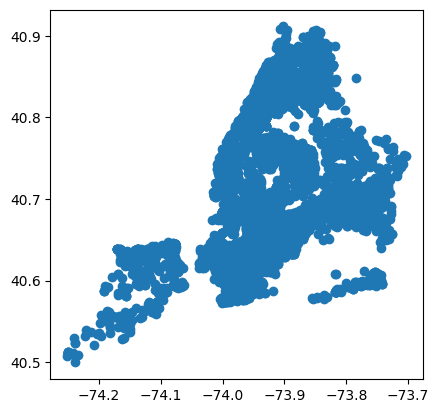

In [13]:
data2.plot()

In [14]:
data2['date_cmpln'].sort_values().head(5)

145     1973-01-19
1090    1973-02-08
263     1984-05-01
1928    1985-01-01
1474    1989-02-17
Name: date_cmpln, dtype: object